In [1]:
include("../scripts/ideal_robot.jl")

In [2]:
using Distributions
using Random

In [3]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
    bias_rate_nu
    bias_rate_omega
    stuck_pdf
    escape_pdf
    time_until_stuck
    time_until_escape
    is_stuck
    kidnap_pdf
    time_until_kidnap
    kidnap_dist
end


In [30]:
function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60,
    bias_rate_stds=(0.1,0.1), expected_stuck_time=1e100, expected_escape_time = 1e-100,
    expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0))
    rbt = Robot(ntuple(x->nothing, fieldcount(Robot))...)
    rbt.pose = pose
    rbt.r = 0.2
    rbt.agent = agent
    rbt.sensor = sensor
    rbt.poses = [pose]
    rbt.color = color
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    rbt.bias_rate_nu = rand(Normal(1, bias_rate_stds[1]))
    rbt.bias_rate_omega = rand(Normal(1, bias_rate_stds[2]))
    rbt.stuck_pdf = Exponential(expected_stuck_time)
    rbt.escape_pdf = Exponential(expected_escape_time)
    rbt.time_until_stuck = rand(rbt.stuck_pdf)
    rbt.time_until_escape = rand(rbt.escape_pdf)
    rbt.is_stuck = false
    rbt.kidnap_pdf = Exponential(expected_kidnap_time)
    rbt.time_until_kidnap = rand(rbt.kidnap_pdf)
    rx = kidnap_range_x
    ry = kidnap_range_y
    rbt.kidnap_dist = (Uniform(rx[1], rx[2]), Uniform(ry[1], ry[2]), Uniform(0, 2*pi))
    return rbt
end

Robot

In [31]:
function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

noise (generic function with 1 method)

In [32]:
function bias(self::Robot, nu, omega)
    return nu*self.bias_rate_nu, omega*self.bias_rate_omega
end

bias (generic function with 1 method)

In [48]:
function stuck(self::Robot, nu, omega, time_interval)
    if self.is_stuck
        self.time_until_escape -= time_interval
        if self.time_until_escape <= 0.0
            self.time_until_escape += rand(self.escape_pdf)
            self.is_stuck = false
        end
    else
        self.time_until_stuck -= time_interval
        if self.time_until_stuck <= 0.0
            self.time_until_stuck += rand(self.stuck_pdf)
            self.is_stuck = true
        end
    end
    return nu*(!self.is_stuck), omega*(!self.is_stuck)
end

stuck (generic function with 1 method)

In [49]:
function kidnap(self::Robot, pose, time_interval)
    self.time_until_kidnap -= time_interval
    if self.time_until_kidnap <= 0.0
        self.time_until_kidnap += rand(self.kidnap_pdf)
        return [rand(self.kidnap_dist[1]), rand(self.kidnap_dist[2]), rand(self.kidnap_dist[3])]
    else
        return pose
    end
end

kidnap (generic function with 1 method)

In [50]:
function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    nu, omega = bias(self, nu, omega)
    nu, omega = stuck(self, nu, omega, time_interval)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
    self.pose = kidnap(self, self.pose, time_interval)
end

one_step (generic function with 3 methods)

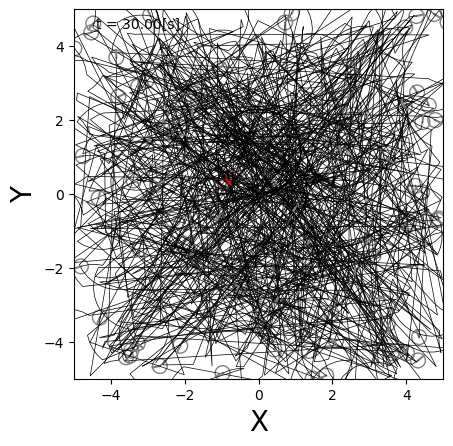

In [58]:
world = World(30, 1.0)
for i in 1:100
    circling = Agent(0.2, 10.0/180*pi)
    r = Robot([0.0,0.0,0.0], circling, nothing, "gray", 0.0, 0.0 , (0.0, 0.0), 1e100, 1e-100, 5)
    append(world, r)
end

r = IdealRobot([0.0, 0.0, 0.0], circling, nothing, "red")
append(world, r)

draw(world)

In [59]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQALOy5tZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAANPdliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYMBddr4mCv8tMgD1mrti3cSjlREQQ+gGgVhjrQfnkS/amzGa1eELF6+wK161nDUfGIURASgqkXhWaQHyk0G3UWAwyDATCrPrg7ukzpfzaLhi+kEbruw9Np56SR+Od8s8wpzm3wbtvjExvp///5n/bGVu5SdQAA7hmeqs0to/A2coHLq3Jf+Js2bpsVCvFBHUoVAntyW4ruBJhstGZ/BoXe/akkU6qH/wlFV+Zp1qBB1bkUQDJkY/FSeyIeVO+3IwTr+93vulA1VX322bsWeJuwm7x+yiFYRMl8lQiYPJX6+z9qV09KAhkspsoX6YWF03Qopvm5ZYb8K0yuXy30aVy+gWShdswvz8O7x141daKvc64ySX3QoXBazia3Z1ejoQVY9MbPmjjgL3PSvBA23ckBs0XnxsN1px8gZc3N2VJUxJ+NVocdMDe7wjfXEOi4DUFzUCQExu4l4KcGs++kdA1z3mTGBNHiJrEu4EXJ/EHD8XYZGqxQcLLQxLFE1J4RjxIdQ0M4C4yPEGY/Tap5/Nv2cBVHO5qzuO/5s6T/HO8hsHtd5on7+ezRX6cL3WuSndGruae8erB/e8JgzQNLq8euDhYdB/ixP8tU3teG9IPsWYfcbjbVOOo1jIicui/UKWSWsNqWyIzA/8Fr+q/pCjw44kOv8ScvlQqOORZdZOMx8HP3AVxpB1lbXJV1BGXcnRRiLRiEDLdwktcrCLnbfNORLm25SYSV4LJ/Y+YQDu8Q1QU4/vaikWHRkknMW98zZ+PLXv3qRjQ8l/wVf1eBot7rR9Ph6o+TcQs3uUjuEYRJ2ER//4uh3dxQQUG1q04etZ55ebIAq56k5FcHjKd2/8QCj+xbz+mHRea5BGLNPsgGQuEMWEcKs/VaycPeG4WQRTl8Qh4XnOb32i0wWmKwyFPN5UMvjgIURyrWfQn3x+jTSP7doPPF7HAa2jjKbQcLw/RJvGclSYPMVql1Dwihq9hcudtuJ6U7dMUpemiEjATAQixYvAA5WJXsqUCEZSPHDJJJhDcQIbwFpZQGJ80AvuOo0KOtL/QkI8RG3pPn18DRQlbHAurFV91pE9w+BuKE2rUqCFSTREDYlr1ysKwnDAA1Vh+kwaFIsUHFJujp4dToCh5rwyFR+mm8njLBbk91+0vg1NEr3twBYHy000tgwfMwo92ycb3QCTAdGa2eLHNMMlbQEbnWK26RmrSOd8T8cLYSOCmW6J5pSnSEOTvz2X7E97KL3kXwgu294nsW/IwZM9AG/B9rIQlykIj4EJzYUqcopcZfPmr5i6YEjl9iakFbx4gAia0QZY6twCfFhETOA385qNmR1gT9MjDHq21c9sZpW+A7r9KEZAvrF1xr6+sMQg2yZrdcEk8niqLmgHqL0b8obRH+yWoXyx2LU3XEIwaJ95ejarJCOWC6/QtmENqxMGC7x8q9w0rZ6tIzr7P8zR/wE6nfhgNRfKP3ZGx2SiBl3DoewyzTZWnmKZ7OZOHYRh6GjT8GqpRnOyKW6p5ZItMByewplm/lalKz+wi+53xb1dMFViQhpubLna0U55rMXE5wri3xeAAnSXNEgqOMQZvWSIf4AA9CqDiz9tNZf/hodqjKWhqHM0eQUuftlW96ld+HYpqNOhY/uapDanQPGqhescTPLhVokDOiFoByGUynCgp9V47w1plBsCNaQ5rTjetE6R4tVbTfGrFi40FUMbOPYRgx3LsJ+N1giskCzCj2NVJHutiuhhuGMcZEUmG+QCIkwA4XYfvnRt+IGqPkJKSC9jMsh2q4QN4aPtBQoeq1rm5mQ6LEtJTkThZejKrGpnMXYrOhx9snLtRDuAvQYpMOLfASt/ONdvsvWiJ13SSdr8xowKbNmRbJus/8xJ21HseuiHNY6jvvsW/hQbSlS/M28vonNCF6XdyBjG1cfWwUXmEzqkXA8lCgoyVkxS+NBYmGCWVMB7axMotfGztvGTak4gxdgs5TPLhoXRfmQNJ6n5cd5SRcjoQdawHOd7tL6+rBaDJIUNqTaap9Jmi1quXCYTJAyN0f76PfBomEGmgm7fivSQ9y8w2R7xCeqEWPnzZsqcldD6JbTdiDws1lQzC2cdvJmuNezkAXvVzh0ABUm+hCWmOHzVcdy2CAMpRCJ9y51cKcTVNZGS2dmQNdzsCFYpQfE91tAF7z7tDrq/AjFyPu+DymGm2tcjGgwOBtALIszrrfkJOXpLukWOHA+4d44wv9Yh2hUWyXBVCVSN8hIoFwRDtzRph5sSkzQNUqWOKgerihU9qPiTGo0XJL9cVTrpgWWQ6tDNSk/wnYaqT4zJOX9VccxDsJZXpmqh3GOvgSYAx/yHSkbXi+evbCJ5YNKlzdVS3naKEixZ+4ntLV6vyBlw1aefP6r9XSRMMu2pn9HXD0BSINKrRARNuV/3PlNUTJIcPnQCtsKWYxO7++LGRvz9VGLUkZniGtexpZW4cBlEybEZ+9mMho3ehQYCDfCaxM7AK9GeeNv0GPbolB5LyEIdLY5P+Gw7lKV1k1AGUeG8wl+96vu74OGyfElNrzy3weGhNQTt6u4D+Ua4wcavl0DBhBhZvM4AbtvimAJJ35X9mqLGlO8IMk4PMp/GMLee/sx9dkXVuNTh6EDeaz13SJqE/6zZ4ciFlwD/qc37trxUJNlxe7jAK9dd9+6DxX/reQu5Nmr2wiHkpja27t70+YjYCFrKeiBIdlUUgsDD4yT0ciLqX73XmxVaLkl5O5n0Ax7926esUvBCVofalKRhnS5ChAau+11R2fCu/yG94DHKvOwtaCINFgMFjNGNixaoCtlOsT6+zAX+G2sMGi0x2AnxGRNAKuHaWL3Xltryv9W